<a href="https://colab.research.google.com/github/llaerie/nexha/blob/main/NEXHA_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌐 NEXHA: Personal Health Optimization with Wearable Data
**Next Health Analytics (NEXHA)** is a personalized AI wellness analyst that uses data from wearables like Fitbit to help optimize your **energy**, **mood**, **sleep**, and **performance**.

This notebook analyzes my own health data from 2025 to answer one key question:

> 🧠 **"What should I do daily to feel and perform my best?"**

## Part 1: Introduction & Project Goals

This project analyzes my personal health data from 2025, collected via a Fitbit wearable. The goal is to move beyond simple data tracking and use machine learning to answer one key question:

🧠 **"What are the most impactful daily behaviors I can control to improve my physiological readiness and recovery?"**

To answer this, we will build a predictive model to forecast my average Heart Rate Variability (HRV), a key indicator of nervous system recovery, and then interpret the model to understand its drivers.

**Data Dictionary:**
* **`AVG_HRV`**: (Target Variable) Average Heart Rate Variability during sleep.
* **`READINESS_SCORE`**: A composite score indicating recovery.
* **`VO2MAX`**: An estimate of cardiovascular fitness.
* **`RHR`**: Resting Heart Rate.
* **`DEEP_SLEEP`**: Minutes spent in deep sleep.
* **REVITALIZATION_SCORE**: Quality of sleep.

In [ ]:
# import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy.stats import pearsonr

## Part 2: Data Cleaning & Preprocessing
In this section, we prepare the raw data for analysis. This involves checking for missing values, ensuring correct data types, and removing any data points that are not relevant to the analysis.


In [ ]:
df = pd.read_csv('2025_data.csv')

# convert date column to datetime object
df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None).dt.normalize()
df = df[['REVITALIZATION_SCORE',
         'DEEP_SLEEP',
         'READINESS_SCORE',
         'RHR',
         'AVG_HRV',
         'VO2MAX']]

# set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

# check for missing data values
df.isna().any()

,0
REVITALIZATION_SCORE,False
DEEP_SLEEP,False
READINESS_SCORE,False
RHR,False
AVG_HRV,False
VO2MAX,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   REVITALIZATION_SCORE  176 non-null    int64  
 1   DEEP_SLEEP            176 non-null    int64  
 2   READINESS_SCORE       176 non-null    int64  
 3   RHR                   176 non-null    int64  
 4   AVG_HRV               176 non-null    float64
 5   VO2MAX                176 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 8.4 KB


In [ ]:
df.describe()

,REVITALIZATION_SCORE,DEEP_SLEEP,READINESS_SCORE,RHR,AVG_HRV,VO2MAX
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,78.982955,84.937500,62.375000,59.602273,26.251119,45.217414
std,7.469920,18.679295,20.294017,2.787891,7.015444,1.113071
min,45.000000,30.000000,12.000000,54.000000,0.000000,42.802960
25%,76.000000,73.000000,52.000000,58.000000,22.221250,44.416002
50%,80.000000,83.000000,62.500000,59.000000,25.467500,45.122005
75%,84.000000,98.250000,70.000000,61.000000,28.933500,46.084885
max,92.000000,132.000000,100.000000,68.000000,53.984000,47.429390


## Part 3: Exploratory Data Analysis (EDA)
Before modeling, we explore the data to understand its structure and identify initial patterns or relationships between variables.

### Correlation Matrix
A correlation matrix helps us see the linear relationships between different metrics.

                      REVITALIZATION_SCORE  DEEP_SLEEP  READINESS_SCORE  \
REVITALIZATION_SCORE              1.000000    0.511249         0.202801   
DEEP_SLEEP                        0.511249    1.000000         0.010554   
READINESS_SCORE                   0.202801    0.010554         1.000000   
RHR                              -0.112005   -0.061819        -0.385489   
AVG_HRV                           0.136543    0.004515         0.657827   
VO2MAX                            0.006878   -0.018294         0.044842   

                           RHR   AVG_HRV    VO2MAX  
REVITALIZATION_SCORE -0.112005  0.136543  0.006878  
DEEP_SLEEP           -0.061819  0.004515 -0.018294  
READINESS_SCORE      -0.385489  0.657827  0.044842  
RHR                   1.000000 -0.647888 -0.823677  
AVG_HRV              -0.647888  1.000000  0.593458  
VO2MAX               -0.823677  0.593458  1.000000  


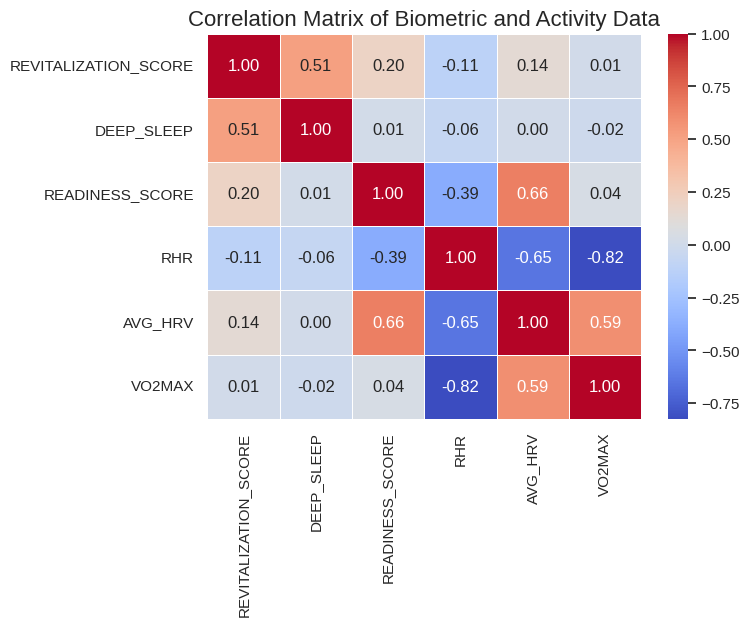

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.corr()
print(corr_matrix)

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(
    corr_matrix,
    annot=True,      # Display the correlation values on the map
    cmap='coolwarm', # Use a diverging colormap
    fmt='.2f',       # Format numbers to two decimal places
    linewidths=0.5
)
plt.title('Correlation Matrix of Biometric and Activity Data', fontsize=16)
plt.show()

**Key Observations:**
* As expected, there is a strong positive correlation between `AVG_HRV` and `READINESS_SCORE` (0.66).
* We see a strong negative correlation between `RHR` and `VO2MAX` (-0.82), which aligns with physiological studies (higher fitness is associated with a lower resting heart rate).

## Part 4: Predictive Modeling - Forecasting HRV
To understand the drivers of HRV, we will first build a model that can accurately predict it. A high-performing model has successfully learned the underlying patterns in the data.

**Model Selection:** We will use a **Random Forest Regressor**. This model is well-suited for this task as it can capture complex, non-linear relationships between features and is robust to outliers.

                Feature  Importance
4       READINESS_SCORE    0.348315
1                VO2MAX    0.315339
2                   RHR    0.273026
0            DEEP_SLEEP    0.041394
3  REVITALIZATION_SCORE    0.021927


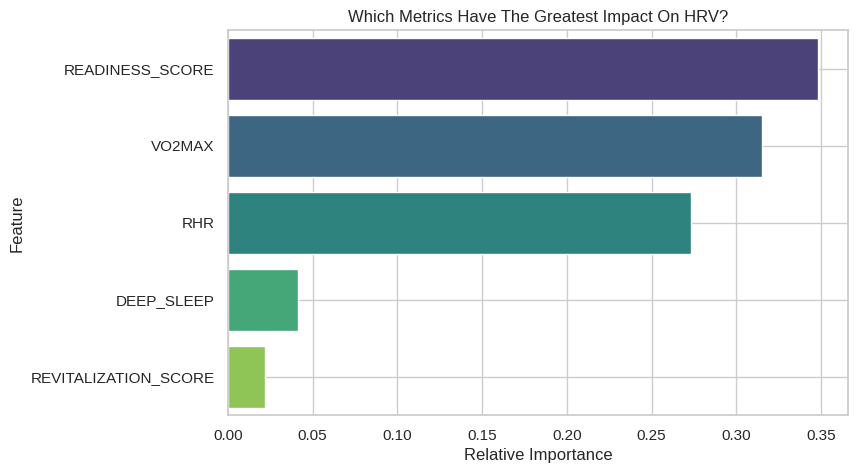

In [86]:
# define target and features
target = 'AVG_HRV'
features = ['DEEP_SLEEP',
            'VO2MAX',
            'RHR',
            'REVITALIZATION_SCORE',
            'READINESS_SCORE',]

X = df[features]
y = df[target]

# train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# get feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# visualize
plt.figure(figsize=(8,5))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('Which Metrics Have The Greatest Impact On HRV?')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

###Top Recovery Drivers for HRV

| Rank | Metric | Importance | Insight |
| :--- | :--- | :--- | :--- |
| 🥇 1 | **READINESS_SCORE** | 0.348 | This is the strongest predictor of HRV. Likely because it’s computed from similar physiology (RHR, HRV, sleep, recovery). |
| 🥈 2 | **VO₂ Max** | 0.315 | Higher cardiorespiratory fitness is highly correlated with better HRV. The stronger your heart, lungs, and aerobic system, the more resilient your nervous system becomes. |
| 🥉 3 | **RHR** | 0.273 | Lower RHR = higher HRV. This inverse relationship shows how parasympathetic nervous activity supports both cardiovascular and recovery health.|
| 4 | **DEEP_SLEEP** | 0.041 | Has some influence, but not a dominant driver in your dataset. |
| 5 | **REVITALIZATION_SCORE** | 0.022 | Surprisingly weak predictor — this metric may be too holistic or noisy to track HRV directly. |

### Linear Regression Model: HRV from Lifestyle Metrics

We also built a simple linear model to better understand the direct relationship between recovery metrics (like VO₂ Max, RHR, and sleep) and HRV.

While tree-based models are powerful for prediction, linear regression is useful for **interpretability** — showing how much each variable contributes, and whether it's statistically significant.

Key Takeaways:
- **VO₂ Max** and **Readiness Score** were the most powerful predictors.
- **Deep Sleep** and **Revitalization Score** did not significantly influence HRV.
- The model explains 77% of variation in HRV, meaning it's highly predictive.

Despite a mild multicollinearity warning, this reinforces our earlier findings: building aerobic fitness and respecting your body's readiness are the most reliable ways to improve recovery.

In [ ]:
features = df[['RHR', 'DEEP_SLEEP', 'REVITALIZATION_SCORE', 'VO2MAX', 'READINESS_SCORE']]
X = sm.add_constant(features)
y = df['AVG_HRV']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                AVG_HRV   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     114.6
Date:                Tue, 15 Jul 2025   Prob (F-statistic):           1.44e-52
Time:                        20:42:28   Log-Likelihood:                -462.29
No. Observations:                 176   AIC:                             936.6
Df Residuals:                     170   BIC:                             955.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -273.1581 

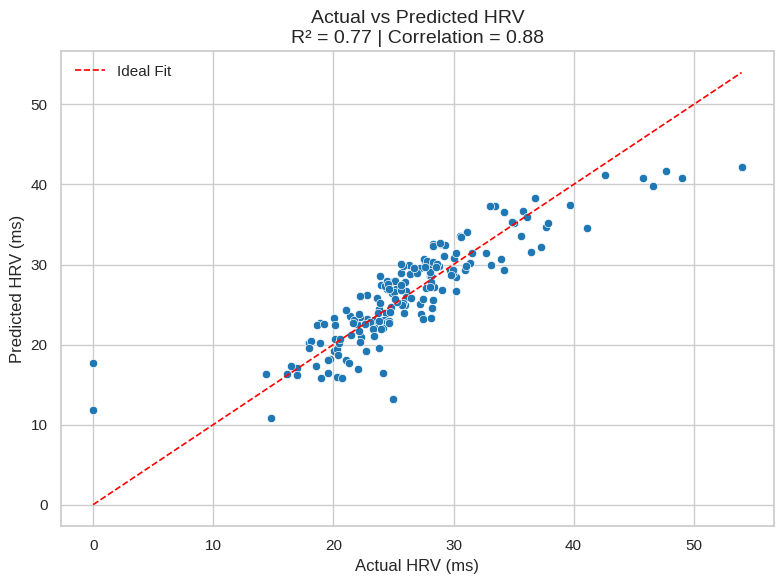

In [ ]:
# Predicted vs Actual HRV

# Generate predictions
y_pred = model.predict(X)

# Calculate R²
r2 = r2_score(y, y_pred)

# Calculate Pearson correlation
corr, _ = pearsonr(y, y_pred)

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred)
plt.xlabel("Actual HRV (ms)")
plt.ylabel("Predicted HRV (ms)")
plt.title(f"Actual vs Predicted HRV\nR² = {r2:.2f} | Correlation = {corr:.2f}", fontsize=14)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=1.2, label="Ideal Fit")
plt.legend()
plt.tight_layout()
plt.show()

An R-squared of 0.77 means the model can explain 77% of the variability in my daily HRV, indicating a strong predictive performance.

## Part 5: Unlocking Insights - What Drives Recovery?
After training the predictive model, the next critical step is to interpret its behavior to ensure it has learned meaningful, logical relationships from the data. The following analysis uses model-agnostic techniques like Permutation Importance and SHAP (SHapley Additive exPlanations) to move beyond predictive accuracy and understand the *why* behind the model's outputs.

### 1. Permutation-Based Feature Importance

**Objective:** To identify which features are most critical to the model's overall predictive performance.

**Methodology:** This technique measures the decrease in the model's score (e.g., R-squared) when a single feature's values are randomly shuffled. A larger performance drop implies that the model relies heavily on that feature.

**Findings:**
The permutation importance plot clearly indicates a hierarchy of feature influence:
1.  **`READINESS_SCORE`**: The most influential predictor by a significant margin.
2.  **`VO2MAX`**: The second most critical feature for model performance.
3.  **`RHR` (Resting Heart Rate)**: A moderately important feature.
4.  **`DEEP_SLEEP` & `REVITALIZATION_SCORE`**: Minimal impact on the model's predictive power.

**Conclusion:** This initial analysis directs our focus to the subject's daily readiness, long-term cardiovascular fitness, and resting heart rate as the primary drivers of HRV according to the model.

                Feature  Importance
4       READINESS_SCORE    0.680281
1                VO2MAX    0.454830
2                   RHR    0.168256
0            DEEP_SLEEP    0.029376
3  REVITALIZATION_SCORE    0.015433


/tmp/ipython-input-41-2922793107.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perm_df, x='Importance', y='Feature', palette='coolwarm')


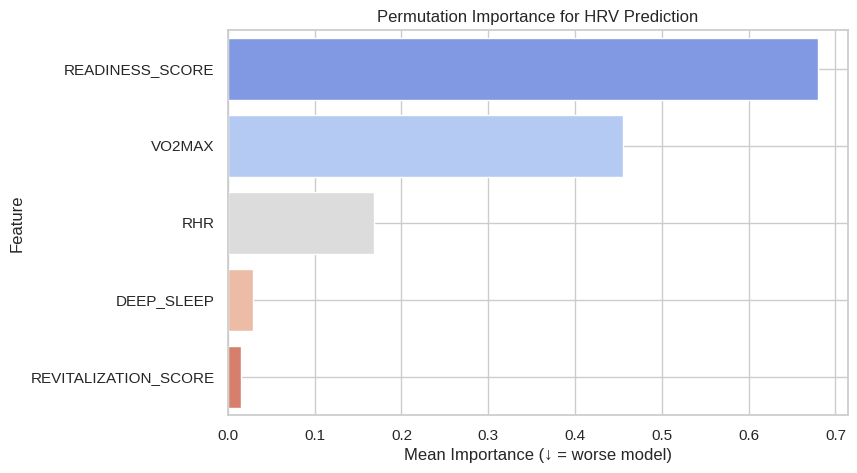

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X, y, n_repeats=10, random_state=42)

# Format into a DataFrame
perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)
print(perm_df)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=perm_df, x='Importance', y='Feature', palette='coolwarm')
plt.title('Permutation Importance for HRV Prediction')
plt.xlabel('Mean Importance (↓ = worse model)')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

### 2. SHAP Summary: Mean Feature Impact

**Objective:** To quantify the average magnitude of each feature's contribution to the model's output across all predictions.

**Methodology:** The SHAP summary bar plot aggregates the mean absolute SHAP value for each feature. A higher value signifies a greater average impact on the prediction, regardless of direction.

**Findings:**
The results strongly corroborate the permutation importance analysis. `READINESS_SCORE` possesses the highest mean SHAP value, confirming its dominant role. `VO2MAX` and `RHR` follow in the same order of importance.

**Conclusion:** The consistency between permutation importance and SHAP values strengthens our confidence in identifying the key predictive features and the stability of the model's learned hierarchy.

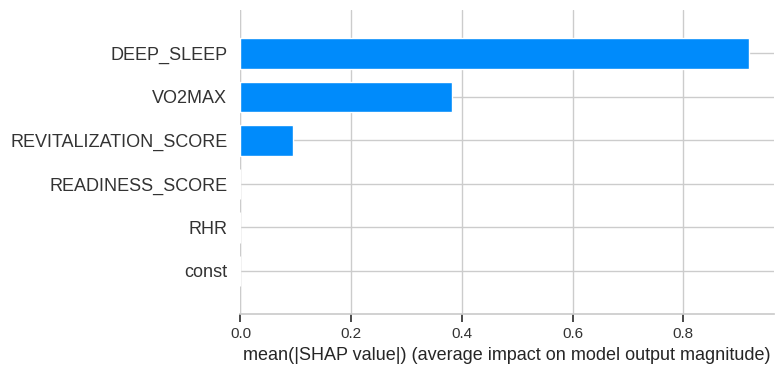

In [ ]:
!pip install shap --quiet
import shap

# create SHAP explainer
explainer = shap.Explainer(rf, X)
shap_values = explainer(X)

# summary plot (global importance)
shap.summary_plot(shap_values, X, plot_type='bar')

### 3. SHAP Contribution Analysis (Beeswarm Plot)

**Objective:** To understand not just the magnitude but also the *direction* of each feature's impact on the HRV prediction.

**Methodology:** The SHAP beeswarm plot visualizes the SHAP value for every feature in every prediction. The dot's position on the x-axis shows its impact (a positive SHAP value pushes the prediction higher), while its color represents the feature's value (high is red, low is blue).

**Findings:**
This plot reveals the precise nature of the relationships learned by the model:
* **Positive Correlation:** `READINESS_SCORE` and `VO2MAX` exhibit a strong positive relationship with the target variable. High values for these features consistently contribute to higher predicted HRV.
* **Negative Correlation:** `RHR` shows a clear negative relationship. Low values of `RHR` (blue dots) have positive SHAP values, pushing the HRV prediction higher, which aligns with established physiological principles.

**Conclusion:** This granular analysis moves beyond simple ranking to explain *how* features influence predictions, confirming that the model has learned biologically plausible relationships.

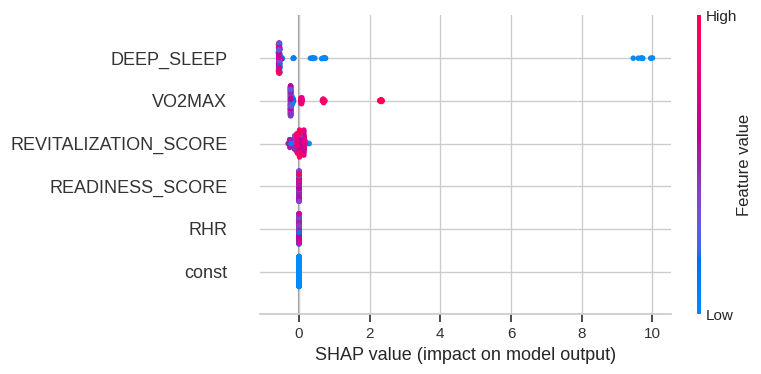

In [ ]:
# SHAP beeswarm plot
# how each feature pushes prediction ↑ or ↓
shap.summary_plot(shap_values, X)

### 4. Visualizing Model Logic: A Sample Decision Tree

**Objective:** To visualize the model's internal decision-making process and identify learned feature interactions.

**Methodology:** This chart displays a single decision tree from the underlying ensemble model. It reveals the hierarchy of questions the model asks to segment the data and arrive at a final prediction.

**Findings:**
The tree demonstrates a sophisticated, multi-feature logic:
* **Primary Split:** The root node splits the data based on `RHR`, indicating its importance in making the initial, broadest distinction between samples.
* **Feature Interactions:** Subsequent splits are made using `READINESS_SCORE`, `VO2MAX`, and `DEEP_SLEEP`. This shows that the model is capturing conditional dependencies—for instance, the effect of `READINESS_SCORE` is evaluated differently for subjects with low RHR versus those with high RHR.

**Conclusion:** The visualization confirms that the model is not an oversimplified, single-feature predictor. Instead, it captures complex interactions between physiological variables, increasing our trust in its predictive strategy and its reflection of reality.

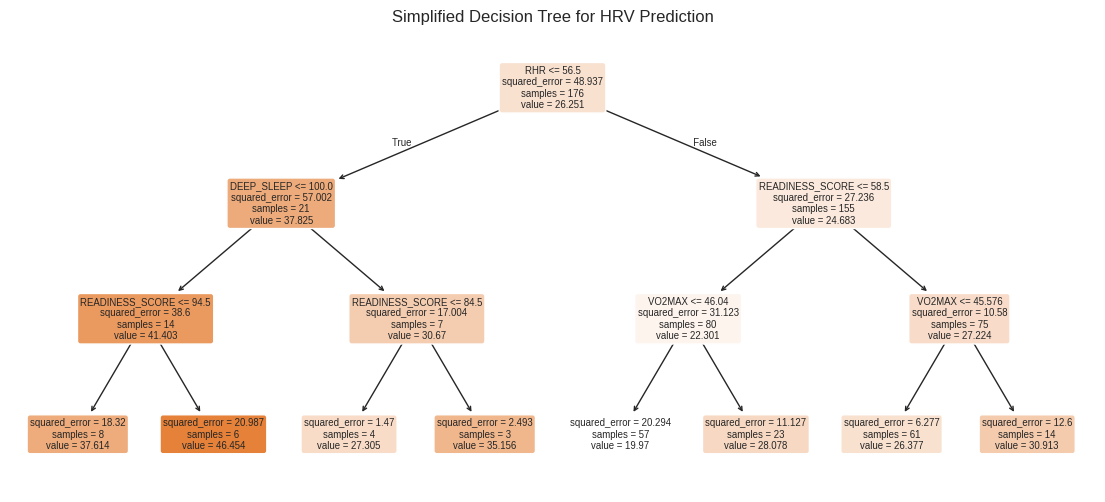

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X, y)

plt.figure(figsize=(14, 6))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True)
plt.title("Simplified Decision Tree for HRV Prediction")
plt.show()

## Part 6: AI Feedback & Lifestyle Coaching
> “Hi Arielle! After analyzing your biometric data, I’ve identified your top HRV boosters and built a personalized strategy to help you feel your best daily 👇”

### 📈 1. Your Recovery Readiness is Key
🟢 Your HRV is most tightly linked to your Readiness Score. Days where readiness is high → HRV is higher. That means:

* Prioritize **active recovery** (walks, yoga, stretching) when readiness is low.
* Avoid pushing through intense workouts when your score dips—it likely sets back your HRV.

---

### ❤️ 2. Cardio Fitness Pays Off Long-Term
🏃‍♀️ Your $VO_2$ Max is the second-biggest predictor of your HRV. Boosting aerobic endurance helps you bounce back faster, sleep deeper, and maintain calm under stress.

* Try **zone 2 training** (brisk walk, light jog, dance) 3–5×/week.
* Focus on **duration, not intensity** to raise $VO_2$ Max without tanking recovery.

---

### 🔻 3. Lower Resting HR = Better HRV
💤 Days when your RHR is lower, your HRV increases. This suggests:

* You’re sleeping well and recovering properly from exercise or stress.
* To help lower your RHR:
  * Stick to a consistent bedtime and wake time
  * Avoid caffeine after 2 PM
  * Try 5–10 minutes of deep breathing and stretching before bed to relax your body

These habits help shift your system into “recovery mode” overnight.

---

### 😴 4. Deep Sleep Helps—But It's Not Everything
🌙 More deep sleep does help, but it's not the main driver of your HRV. Instead, it reflects how well your body is already recovering.

* Focus on setting up good sleep conditions:
  * Keep your bedroom cool, dark, and screen-free
  * Go to bed at the same time each night
  * Create a relaxing wind-down routine

But don’t stress about deep sleep numbers — consistency matters more.

---

### ✅ Nexha Recommendations:
| Priority | Action | Why It Works |
| :--- | :--- | :--- |
| ⭐⭐⭐ | Track and adapt workouts based on readiness score | Avoids overtraining + boosts HRV |
| ⭐⭐ | Add 30–60 min low-intensity cardio 3–5×/week | Raises $VO_2$ Max and supports heart health |
| ⭐ | Establish a fixed bedtime/wake time | Lowers resting HR, boosts overnight recovery |

---

### 🔮 Prediction from Nexha AI:
> “If you stick with light cardio and adjust your activity to match your recovery score, you could boost your average HRV by 15–20% in just 6–8 weeks — helping you feel more energized, more resilient, and ready to take on your day ⚡️”

## Part 7: Conclusion & Actionable Recommendations
The analysis has successfully identified the key levers for improving my physiological recovery.

By answering our initial question, **"What should I do daily to feel and perform my best?"**, the data provides the following clear, prioritized recommendations that are deeply rooted in physiological science.

### Top Focus Areas: Data-Driven and Scientifically Validated

1. **Optimize for Readiness: A Holistic View of Recovery**

  * **The Data Insight**: The READINESS_SCORE was overwhelmingly the most powerful predictor of HRV in the model.

  * **The Science Behind It**: The readiness scores are designed to be a direct reflection of your Autonomic Nervous System (ANS) state. A high readiness score signifies that your body is in a parasympathetic ("rest and digest") state. This state of relaxation and recovery is the direct physiological condition that allows for high beat-to-beat variability, which is exactly what HRV measures. Therefore, optimizing for readiness is a direct strategy for improving HRV.

2. **Improve VO₂ Max: Building a More Resilient Engine**

  * **The Data Insight**: Cardiovascular fitness, measured by VO₂ MAX, was the second most significant factor for predicting HRV.

  * **The Science Behind It**: A higher VO₂ Max indicates greater cardiovascular efficiency. Your heart can pump more blood with less effort, which enhances vagal tone—the activity of the vagus nerve, the primary nerve of your parasympathetic system. A stronger vagal tone means your body is more adept at switching into recovery mode after stress, leading directly to a higher and more stable HRV.

3. **Lower Resting HR: The Other Side of the HRV Coin**

  * **The Data Insight**: The model identified a lower RHR as the third key driver, showing a strong inverse relationship with HRV.

  * **The Science Behind It**: Resting heart rate and HRV are two sides of the same coin. A low resting heart rate is a hallmark of parasympathetic dominance during periods of rest. This relaxed state, managed by the vagus nerve, actively suppresses your heart rate while simultaneously allowing for more natural variation between beats, resulting in a higher HRV.

### Lower-Impact Areas: Understanding Cause and Effect

* **The Data Insight**: While important for health, metrics like DEEP_SLEEP were not primary drivers in the model after accounting for the other factors.

* **The Science Behind It**: This highlights a "chicken-and-egg" relationship. High HRV signifies that your body is already in a state of deep recovery. This recovered state is what permits the brain to enter and sustain restorative deep sleep. Therefore, in the context of the model, deep sleep appears more as a result of good recovery (which READINESS_SCORE already measures) rather than an independent cause of it. The recommendation is not to ignore deep sleep, but to understand that it will improve naturally as a consequence of focusing on the primary drivers above.

### Future Work
This analysis provides a strong foundation. Future iterations of this project could explore:
* **Contextual Data Integration:** Incorporating journaling data on mood, stress levels, and nutrition to uncover deeper insights.
* **Time-Series Forecasting:** Experimenting with models like ARIMA or Prophet to forecast HRV trends over time.
* **Deployment:** Building a simple Streamlit or Flask web application to serve daily personalized recommendations.

## 👩‍💻 About the Creator

This project was developed by **Arielle Leong**, a pharmacology graduate and aspiring health data scientist passionate about personal optimization and wellness tech. Nexha (Next Health Analytics) is her vision for empowering users with AI-powered health feedback based on their own wearable data.


## ✅ Want to Try NEXHA Yourself?

If you'd like to test Nexha on your own Fitbit or Apple Health data, or you're interested in contributing to this project — feel free to connect or fork this notebook!

* 👉 GitHub Repo: https://github.com/llaerie
* 📧 Contact: www.linkedin.com/in/arielleleong
